In [0]:
import cv2
import numpy as np
import os

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

path = '/content/drive/My Drive/bw-colorization'
os.chdir(path)
os.listdir('.')

['images', 'model', 'bw2color_image.py', '.DS_Store', 'bw2color_video.py']

In [0]:
args = {'input':'/content/drive/My Drive/vid.mp4', 'image':'/content/drive/My Drive/Data/Test/vVO50J.jpg', 'points':path+'/model/pts_in_hull.npy','prototxt':path+'/model/colorization_deploy_v2.prototxt', 'model':path+'/model/colorization_release_v2.caffemodel'}

In [0]:
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])
pts = np.load(args["points"])
 
# add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

[INFO] loading model...


In [0]:
# load the input image from disk, scale the pixel intensities to the
# range [0, 1], and then convert the image from the BGR to Lab color
# space
image = cv2.imread(args["image"])
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

In [0]:
# resize the Lab image to 224x224 (the dimensions the colorization
# network accepts), split channels, extract the 'L' channel, and then
# perform mean centering
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

In [0]:
# pass the L channel through the network which will *predict* the 'a'
# and 'b' channel values
'print("[INFO] colorizing image...")'
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
 
# resize the predicted 'ab' volume to the same dimensions as our
# input image
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

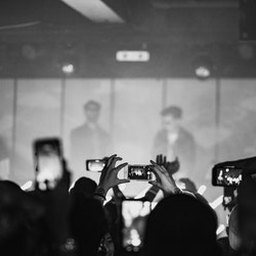

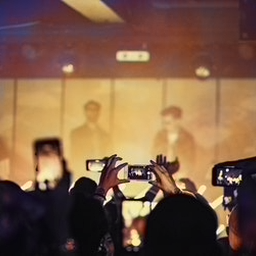

-1

In [0]:
# grab the 'L' channel from the *original* input image (not the
# resized one) and concatenate the original 'L' channel with the
# predicted 'ab' channels
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
 
# convert the output image from the Lab color space to RGB, then
# clip any values that fall outside the range [0, 1]
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)
 
# the current colorized image is represented as a floating point
# data type in the range [0, 1] -- let's convert to an unsigned
# 8-bit integer representation in the range [0, 255]
colorized = (255 * colorized).astype("uint8")
 
# show the original and output colorized images
cv2_imshow(image)
cv2_imshow(colorized)
cv2.waitKey(0)

In [0]:
from imutils.video import VideoStream
import time
import imutils

In [0]:
# initialize a boolean used to indicate if either a webcam or input
# video is being used
webcam = not args.get("input", False)
 
# if a video path was not supplied, grab a reference to the webcam
if webcam:
	print("[INFO] starting video stream...")
	vs = VideoStream(src=0).start()
	time.sleep(2.0)
 
# otherwise, grab a reference to the video file
else:
	print("[INFO] opening video file...")
	vs = cv2.VideoCapture(args["input"])

[INFO] opening video file...


In [0]:
# load our serialized black and white colorizer model and cluster
# center points from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])
pts = np.load(args["points"])
 
# add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

[INFO] loading model...


In [0]:
frame = vs.read()
print(len(frame[1]))

360


In [0]:
num_of_frames = 0
frame_arr = []
fps = 25
size = (224,224)
pathOut = 'video.avi'
# loop over frames from the video stream
while True:
	# grab the next frame and handle if we are reading from either
	# VideoCapture or VideoStream
	frame = vs.read()
	frame = frame if webcam else frame[1]
 
	# if we are viewing a video and we did not grab a frame then we
	# have reached the end of the video
	if not webcam and frame is None:
		break
	num_of_frames+=1
	# resize the input frame, scale the pixel intensities to the
	# range [0, 1], and then convert the frame from the BGR to Lab
	# color space
	frame = imutils.resize(frame, width=500)
	scaled = frame.astype("float32") / 255.0
	lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
 
	# resize the Lab frame to 224x224 (the dimensions the colorization
	# network accepts), split channels, extract the 'L' channel, and
	# then perform mean centering
	resized = cv2.resize(lab, (224, 224))
	L = cv2.split(resized)[0]
	L -= 50
	# pass the L channel through the network which will *predict* the
  # 'a' and 'b' channel values
	net.setInput(cv2.dnn.blobFromImage(L))
	ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
 
	# resize the predicted 'ab' volume to the same dimensions as our
	# input frame, then grab the 'L' channel from the *original* input
	# frame (not the resized one) and concatenate the original 'L'
	# channel with the predicted 'ab' channels
	ab = cv2.resize(ab, (frame.shape[1], frame.shape[0]))
	L = cv2.split(lab)[0]
	colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
 
	# convert the output frame from the Lab color space to RGB, clip
	# any values that fall outside the range [0, 1], and then convert
	# to an 8-bit unsigned integer ([0, 255] range)
	colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
	colorized = np.clip(colorized, 0, 1)
	colorized = (255 * colorized).astype("uint8")
	
		# show the original and final colorized frames
	cv2_imshow(frame)
	#cv2_imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
	frames_arr.append(colorized)
  
	#cv2_imshow(colorized)
	key = cv2.waitKey(1) & 0xFF
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_arr)):
        # writing to a image array
        out.write(frame_arr[i])
out.release()
# if we are using a webcam, stop the camera video stream
if webcam:
	vs.stop()

# otherwise, release the video file pointer
else:
	vs.release()

# close any open windows
cv2.destroyAllWindows()

print(num_of_frames)


74


In [0]:
# if we are using a webcam, stop the camera video stream
if webcam:
	vs.stop()

# otherwise, release the video file pointer
else:
	vs.release()

# close any open windows
cv2.destroyAllWindows()


In [0]:
my_vid = cv2.VideoCapture('/content/Video.mp4')